In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [5]:
 ids = [192,  196,  207,  243,  600,  780,  965, 1021, 1155, 1258, 1316,
       1483, 1568, 1671, 2068, 2242, 2373, 2634, 2712, 2928, 3170, 3609,
       3695, 3982, 4007, 4269, 4657, 4759, 4783, 5196, 5297, 5345, 5523,
       5596, 6112, 6241]

In [6]:
len(ids)

36

In [7]:
isin = df.loc[df['caseid'].isin(ids)]

In [20]:
# shrink dataset to the first 6 cases 
caseids = isin.caseid.unique()
caseids


array([ 192,  196,  207,  243,  600,  780,  965, 1021, 1155, 1258, 1316,
       1483, 1568, 1671, 2068, 2242, 2373, 2634, 2712, 2928, 3170, 3609,
       3695, 3982, 4007, 4269, 4657, 4759, 4783, 5196, 5297, 5345, 5523,
       5596, 6112, 6241])

In [9]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [21]:
MINUTES_AHEAD = 5  # Predict hypotension 5 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [22]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (250 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 250]
        segy = mbps[i + 250 + MINUTES_AHEAD * 30:i + 250 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 192...4214 samples 268 (6.4 %) events
loading 196...3888 samples 520 (13.4 %) events
loading 207...4273 samples 0 (0.0 %) events
loading 243...1344 samples 0 (0.0 %) events
loading 600...4289 samples 0 (0.0 %) events
loading 780...5564 samples 1144 (20.6 %) events
loading 965...3255 samples 1222 (37.5 %) events
loading 1021...4149 samples 78 (1.9 %) events
loading 1155...5830 samples 388 (6.7 %) events
loading 1258...3327 samples 784 (23.6 %) events
loading 1316...904 samples 0 (0.0 %) events
loading 1483...4523 samples 0 (0.0 %) events
loading 1568...1752 samples 0 (0.0 %) events
loading 1671...2404 samples 1492 (62.1 %) events
loading 2068...399 samples 0 (0.0 %) events
loading 2242...2390 samples 0 (0.0 %) events
loading 2373...1286 samples 0 (0.0 %) events
loading 2634...3572 samples 96 (2.7 %) events
loading 2712...no samples
loading 2928...3729 samples 264 (7.1 %) events
loading 3170...1011 samples 314 (31.1 %) events
loading 3609...630 samples 798 (126.7 %) events
loadin

## Splitting samples into training and testing dataset

In [23]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=100 total 117652, train 83352 (4517 events 5.4%), test 34300 (1027 events 3.0%)'

## Model building and training

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
751/751 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.8893 - auc_1: 0.8590
Epoch 1: val_loss improved from inf to 0.23084, saving model to output/weights.hdf5
751/751 [==============================] - 61s 79ms/step - loss: 0.4860 - accuracy: 0.8893 - auc_1: 0.8590 - val_loss: 0.2308 - val_accuracy: 0.9820 - val_auc_1: 0.2619
Epoch 2/100
751/751 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.9074 - auc_1: 0.8805
Epoch 2: val_loss improved from 0.23084 to 0.05148, saving model to output/weights.hdf5
751/751 [==============================] - 59s 78ms/step - loss: 0.4448 - accuracy: 0.9074 - auc_1: 0.8805 - val_loss: 0.0515 - val_accuracy: 0.9946 - val_auc_1: 0.1469
Epoch 3/100
751/751 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.9068 - auc_1: 0.8815
Epoch 3: val_loss did not improve from 0.05148
751/751 [==============================] - 60s 80ms/step - loss: 0.4431 - accuracy: 0.9068 - auc_1: 0.88

2137

## Evaluation of the model performance

In [26]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [27]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



1072/1072 [==============================] - 19s 17ms/step
auroc=0.811, auprc=0.131 acc=0.963, F1=0.071, PPV=14.9, NPV=97.1, TN=32998, fp=275, fn=979, TP=48


In [28]:
auroc

0.8106825740178818

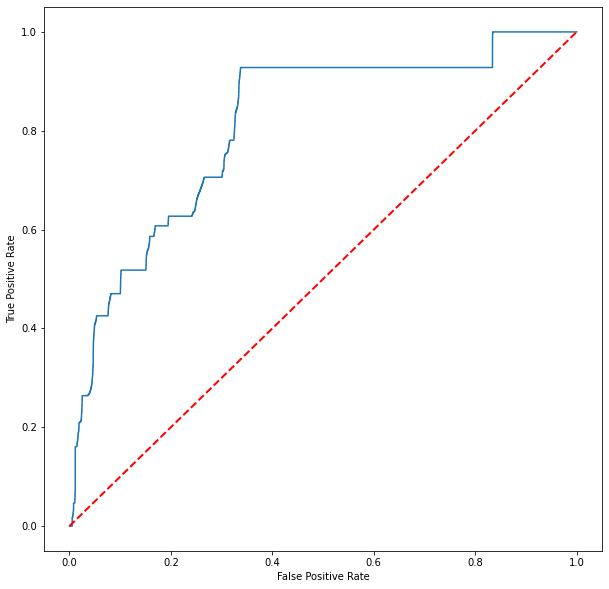

<function matplotlib.pyplot.show(close=None, block=None)>

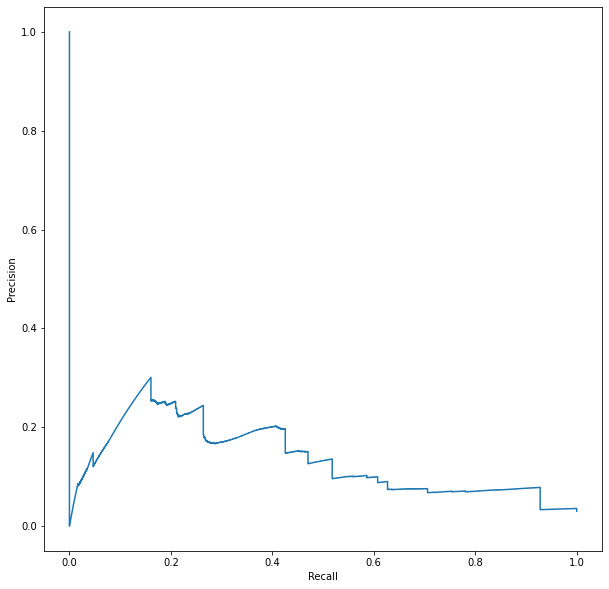

In [29]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

188/188 [==============================] - 4s 19ms/step
Print error: 5196	0.21088043076668195	


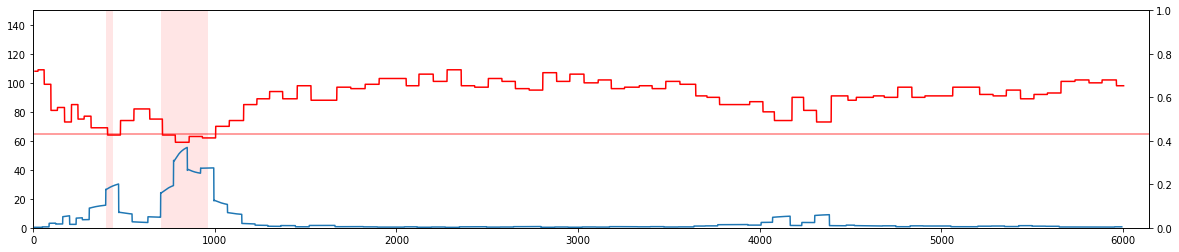

38/38 [==============================] - 1s 21ms/step
Print error: 5297	0.1065356413771771	


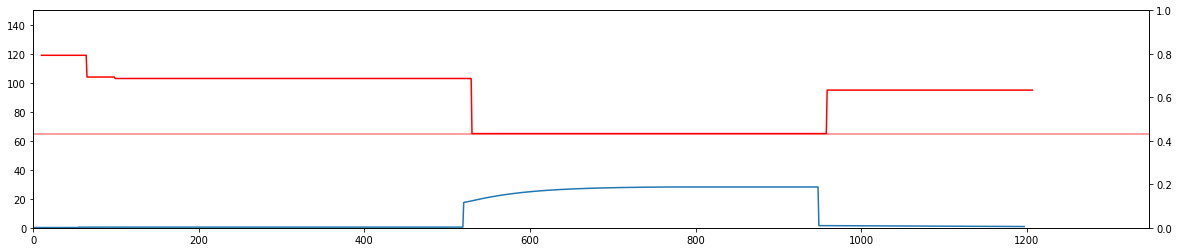

94/94 [==============================] - 2s 18ms/step
Print error: 5345	0.25062665779440674	


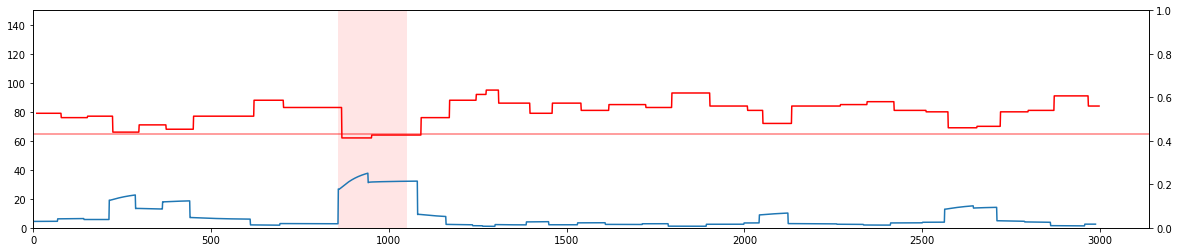

112/112 [==============================] - 2s 18ms/step
Print error: 5523	0.04613923762102632	


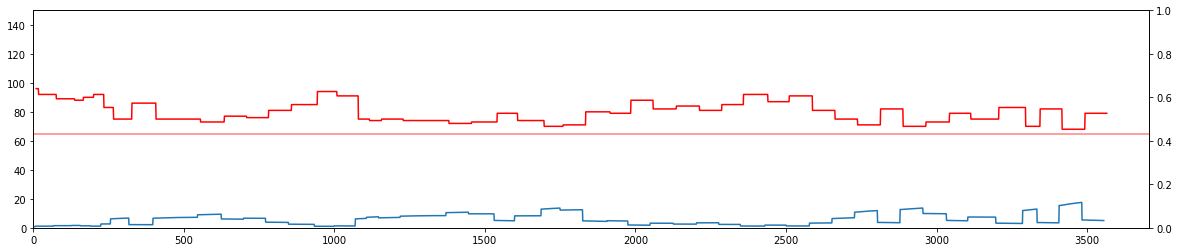

232/232 [==============================] - 4s 19ms/step
Print error: 5596	0.014075230094937094	


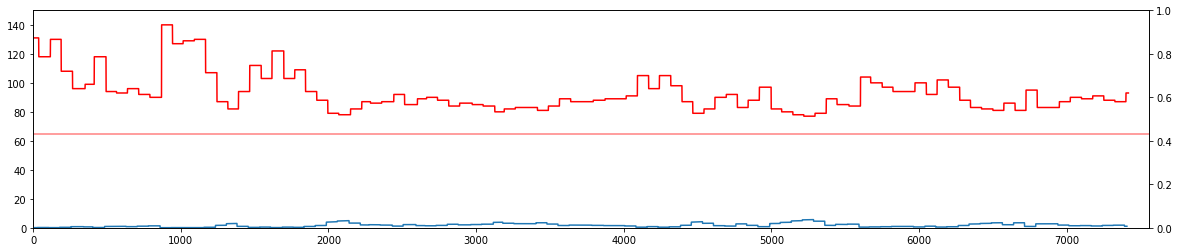

274/274 [==============================] - 5s 19ms/step
Print error: 6112	0.24001227556067847	


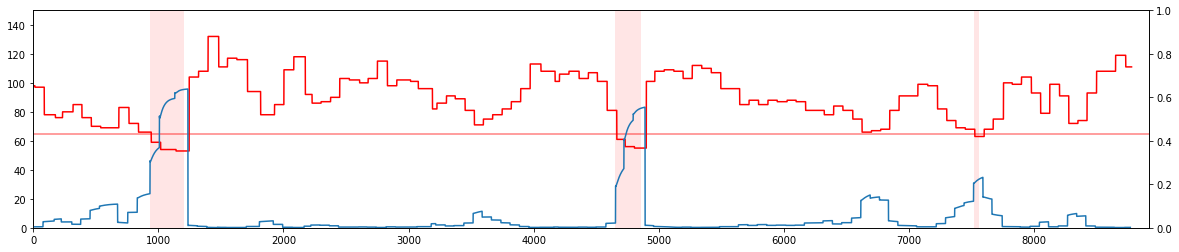

138/138 [==============================] - 3s 21ms/step
Print error: 6241	0.05608020793004455	


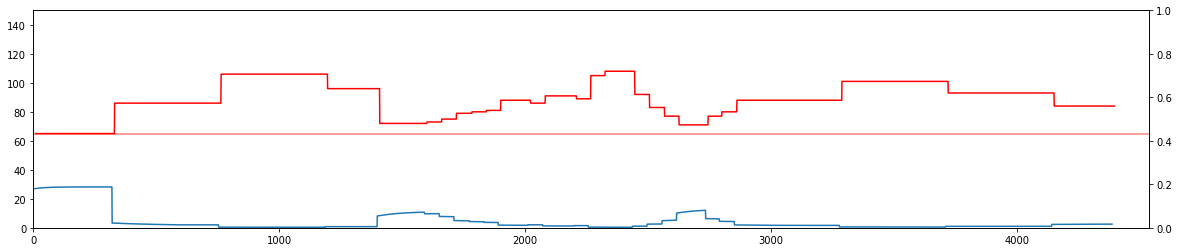

In [31]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()